In [1]:
!apt-get install -y gdal-bin python3-gdal
!pip install rasterio

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  python3-numpy
Suggested packages:
  libgdal-grass python-numpy-doc python3-dev python3-pytest
The following NEW packages will be installed:
  gdal-bin python3-gdal python3-numpy
0 upgraded, 3 newly installed, 0 to remove and 41 not upgraded.
Need to get 5,168 kB of archives.
After this operation, 25.6 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy-updates/main amd64 python3-numpy amd64 1:1.21.5-1ubuntu22.04.1 [3,467 kB]
Get:2 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy/main amd64 python3-gdal amd64 3.8.4+dfsg-1~jammy0 [1,095 kB]
Get:3 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy/main amd64 gdal-bin amd64 3.8.4+dfsg-1~jammy0 [605 kB]
Fetched 5,168 kB in 6s (923 kB/s)
Selecting previously unselected package python3-numpy.
(Reading database ... 121713 files and director

In [6]:
import geopandas as gpd
import rasterio
import numpy as np
import pandas as pd
from rasterio.features import rasterize

In [7]:
path = "Dundalk_Sentinel2_2023.tif"

In [10]:
with rasterio.open(path) as src:
    red   = src.read(4).astype(float)   # B4
    green = src.read(3).astype(float)   # B3
    nir   = src.read(8).astype(float)   # B8
    swir1 = src.read(11).astype(float)  # B11
    swir2 = src.read(12).astype(float)  # B12

# Indices
ndvi = (nir - red) / (nir + red + 1e-10)
ndbi = (swir1 - nir) / (swir1 + nir + 1e-10)
ndwi = (green - nir) / (green + nir + 1e-10)


In [9]:
# Load polygons
Vegetation = gpd.read_file('Green_polygons.geojson')
Soil = gpd.read_file('Soil_polygons.geojson')
Urban = gpd.read_file('Urban_polygons.geojson')
Water = gpd.read_file('Water_polygons.geojson')

In [11]:
# Assign numeric classes
class_mapping = {
    'Vegetation': 1,
    'Soil': 2,
    'Urban': 3,
    'Water': 4
}

Vegetation['class'] = class_mapping['Vegetation']
Soil['class'] = class_mapping['Soil']
Urban['class'] = class_mapping['Urban']
Water['class'] = class_mapping['Water']

In [20]:
raster = rasterio.open(path)

In [21]:
# Combine
all_polygons = pd.concat([Vegetation, Soil, Urban, Water], ignore_index=True)

# Reproject polygons to raster CRS
all_polygons = all_polygons.to_crs(raster.crs)

In [22]:
shapes = [(geom, cls) for geom, cls in zip(all_polygons.geometry, all_polygons['class'])]

label_raster = rasterize(
    shapes=shapes,
    out_shape=(raster.height, raster.width),
    transform=raster.transform,
    fill=0,
    dtype='int32'
)

print("Unique labels:", np.unique(label_raster))
print("Labeled pixels:", np.sum(label_raster != 0))


Unique labels: [0 1 2 3 4]
Labeled pixels: 707911


In [23]:
features = np.stack([ndvi, ndbi, ndwi], axis=0)  # shape = (3, H, W)
bands, height, width = features.shape

In [24]:
# Flatten features: (3, H, W) → (H*W, 3)
X = features.reshape(bands, -1).T

# Flatten labels: (H, W) → (H*W,)
y = label_raster.flatten()


In [25]:
mask = y != 0
X_labeled = X[mask]
y_labeled = y[mask]

print("Pixels available for supervised learning:", len(y_labeled))


Pixels available for supervised learning: 707911


In [26]:
from sklearn.model_selection import train_test_split

# 1) Split into 85% (train+val) and 15% test
X_train_val, X_test, y_train_val, y_test = train_test_split(
    X_labeled, y_labeled, test_size=0.15, random_state=42, stratify=y_labeled
)

# 2) Split train_val into 70% train and 15% val
X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val,
    test_size=0.1765,     # 0.1765 of 85% ≈ 15% total
    random_state=42,
    stratify=y_train_val
)


In [ ]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

In [ ]:
from sklearn.metrics import classification_report, accuracy_score

y_val_pred = rf.predict(X_val)

print("Validation Accuracy:", accuracy_score(y_val, y_val_pred))
print(classification_report(y_val, y_val_pred))

Validation Accuracy: 0.7128383786074102
              precision    recall  f1-score   support

           1       0.73      0.84      0.78     54820
           2       0.32      0.08      0.12       957
           3       0.56      0.40      0.47     26512
           4       0.80      0.80      0.80     23916

    accuracy                           0.71    106205
   macro avg       0.60      0.53      0.54    106205
weighted avg       0.70      0.71      0.70    106205



In [ ]:
y_test_pred = rf.predict(X_test)

print("Test Accuracy:", accuracy_score(y_test, y_test_pred))
print(classification_report(y_test, y_test_pred))

Test Accuracy: 0.7102093476602598
              precision    recall  f1-score   support

           1       0.73      0.83      0.78     54810
           2       0.29      0.07      0.11       957
           3       0.56      0.40      0.47     26507
           4       0.79      0.79      0.79     23913

    accuracy                           0.71    106187
   macro avg       0.59      0.52      0.54    106187
weighted avg       0.70      0.71      0.70    106187



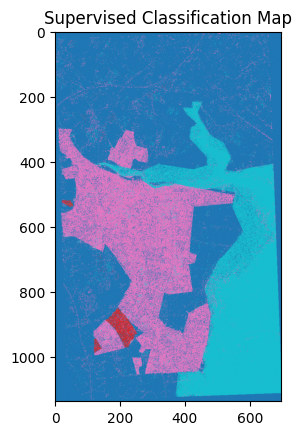

In [ ]:
import matplotlib.pyplot as plt

full_pred = rf.predict(X)

classification_map = full_pred.reshape(height, width)

plt.imshow(classification_map, cmap='tab10')
plt.title("Supervised Classification Map")
plt.show()